In [1]:
# import packages required for this post
from math import sqrt
from matplotlib.colors import LogNorm

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import seaborn as sns

In [2]:
# graphics parameters
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

## Introduction

### The New Kid in Town

Ever since its formation in 2011, [pymetrics](https://www.pymetrics.com/employers/) has taken the recruitment world by storm, attempting to reinvent the way that employers screen their candidates. The prevalence of this company is seen most in the application process for summer internships. Partnered with the likes of Unilever, Accenture, Mercer, and JPMorgan and receiving $40 million in its series B funding round, pymetrics is certainly making its mark on the job application scene.

The philosophy of pymetrics revolves around leveraging neuroscience, AI, and behavioural science to create a bias-free and effective means of matching candidates with recruiters. Rather than your typical numerical literacy or situational awareness tests, pymetrics prides itself on using unconventional 'games' to access a candidate's behaviour and abilities.

Pymetrics claims that its games focus less on assessing the skill-level of a candidate and more on determining how well they fit the job role that they are applying for. Although I believe this for the majority of their games, there are certain games where it is clear that there is an optimal way of playing. In this post we will take a look at one such game in which you have to manage risk in the face of uncertainty. We will reenvision the game through the lens of statistics and data science to gain some insight into how we can solve it effectively. If you are after a way to cheat the system and improve your test score, this post is not for you; if however you are curious about some of the ideas that can be applied to this game as well as many other challenges that require the management of risk, read on, there is a lot in store.

### Bandits!

In this post, we are going to be looking at a particular game from the dozen used by JPMorgan in recruiting for their 2020 summer analyst programme. The setup is as follows: 

* There are four decks of cards (with a large, unknown number of cards) laid face-down next to each other on a table
* You repeatedly choose one of these four decks and draw the top card
* Each card has a monetary value associated with it. It could be +£200, -£600 or +£0.
* You continue this process, free to choose a different deck at any point until the game terminates at some point unknown to you

Simple enough. Once you begin to experiment with your choice of deck, you will quickly notice that each one has a distinctly different behaviour. Perhaps one only gives small positive returns but appears to do so consistently. There could be another deck with a tendency to offer both large rewards and devastating losses. A final deck may offer steady rewards only to suddenly punish you for your optimism with the nasty introduction of a £2000 loss.

This sort of problem also exists outside of the realm of pymetrics games. In the world of statistics and machine learning, it is known as the multi-armed bandit problem. This name comes from imagining a gambler at a row of slot machines (sometimes known as "one-armed bandits"), who has to decide which machine to risk his money on next with the (optimistic) hope that one machine, if he could all but find it, would give him better returns. In particular we are looking at a 4-armed bandit. The multi-armed bandit is an example of reinforcement learning; problems in which an algorithm is designed to make choices and then alter its future decisions based on the response it receives.

As is customary in statistics, if we want to tackle this problem we will have to formulate it as a probabilistic model. To do this, we will have to make some assumptions. 

Although it would be possible to analyse this problem with minimal assumptions—supposing that the arms of the bandit (decks of cards) each have a completely free distribution of rewards—the results we obtain from this are not very insightful, and require large amounts of effort to even reach.

Instead, we shall assume that each arm returns rewards that are normally distributed (i.e. a bell-shaped likelihood curve centered around the most likely reward). We will choose each distribution's mean (centre) and standard deviation (spread) randomly with the value of such parameters unknown to the player.

As assumptions go, these are very relaxed. Most introductory guides to the multi-armed bandit problem start by analysing what is known as a Bernoulli bandit, where each arm is essentially just a biased coin flip—heads giving a reward of £1 and tails taking away the same amount. It's no fun to follow the crowd though, so we will jump right into the deep-end by modelling the game above as a 4-armed normal bandit with unknown means and standard deviations. For a particular selection of these parameters, our reward distributions may look something like this.

In [3]:
class NormalBandit():
    """An n-armed bandit whose rewards are normally distributed.
    
    The mean and standard deviation of each arm's reward distribution
    can either be manually specified or are chosen from normal and
    half-t distributions, respectively"""
    
    def __init__(self, n, mu=None, sigma=None):
        assert mu is None or len(mu) == n
        assert sigma is None or len(mu) == n
        
        self.n = n
        self.mu = rnd.normal(scale=1, size=self.n) if mu is None else mu
        self.sigma = np.abs(rnd.standard_t(self.n, 
                                           self.n)) if sigma is None else sigma

        self.best_mu = max(self.mu)

    def generate_reward(self, i):
        return rnd.normal(self.mu[i], self.sigma[i])

In [4]:
# create 4-armed bandit
np.random.seed(1743)
bandit = NormalBandit(4)

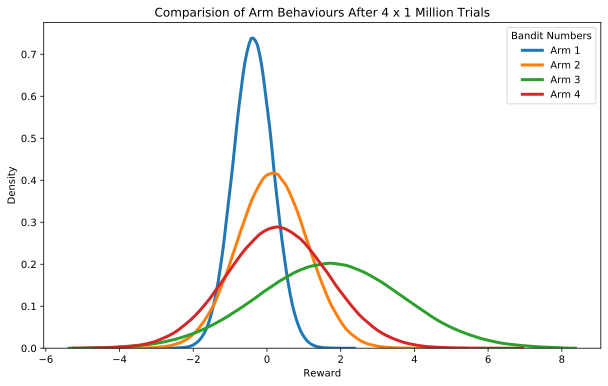

In [5]:
# visualise distributions
def plot_bandit(bandit, iterations=10**6):
    rewards = [[bandit.generate_reward(i) for _ in range(iterations)] for i in range(bandit.n)]
    plt.figure(figsize=(10, 6))
    for i, reward in enumerate(rewards):
        filtered = [r for r in reward if -5 < r < 8]
        sns.distplot(filtered, hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = f"Arm {i+1}")
    plt.legend(title = 'Bandit Numbers')
    plt.title('Comparision of Arm Behaviours After 4 x 1 Million Trials')
    plt.xlabel('Reward')
    plt.ylabel('Density');
plot_bandit(bandit)

### A Dilemma

Looking at the above graph we see what makes this problem so fiendish. When we start playing with a multi-armed bandit, we have no idea what these distributions look like. Only with time and experimentation can we learn the 'behaviour' of each arm. The trouble is that the information we obtain through our initial trials may mislead us. Note for example that because arm 1 has such a low standard deviation (narrow peak) it is actually more likely that arms 2-4 will give us a reward below -2 than arm 1 will. If we started by sampling both arms 1 and 2, it wouldn't be unlikely for our sample from arm 1 to turn out better than arm 2. Despite this, arm 1 is worse on average than arm 2 (it has a lower mean/peak) yet we would not know this from our initial foray.

It is important to remember also that experimentation isn't free. Since the game will eventually end (we have no idea when this will be, but we can at least count on the heat-death of the universe to guarantee it will come) we will only ever be able to earn a finite amount of money and any sub-optimal choices that we made along the way, either through ignorance or desire to experiment, can be looked on with regret. This is how we frame this problem statistically; as an optimisation problem in which we aim to seek a policy (set of rules that determine which arm to use at any given moment) that minimises regret.

This may sound like a reasonable objective but taking a closer look will show us that the situation is more nuanced. It all comes down to _when_ we want to minimise regret. After a thousand or so trials we may be pretty confident on the behaviour of all arms but one. We then have a difficult decision to make. We are confident that of the arms we have frequently used, we know which one is best. We could keep using this indefinitely, reaping reasonable rewards. This seems like a sensible approach but there will always be the question of "what if?". Maybe, just maybe, the other arm we have barely experimented with has a slightly higher reward than our current known best. It could be better by only 10 pence per use but what if the game were to go on for another 1000 turns? Well, those 10 pences add up to a handsome reward. On the other hand, what if the other arm is no good at all? By experimenting with it we are only wasting turns that could have been spent on our known best arm, possibly losing money in the process.

This conundrum is known as the explore-exploit dilemma and is a key concept in the general field of reinforcement learning. As hinted at above, there are two conflicting types of policy that can be used to tackle the multi-armed bandit problem. 

Exploitative policies don't worry about the "what if?"s. They focus on the current known best and keep applying that strategy till the cows come home. 

Exploratory policies are much more cautious. They agonise over the chance that there may be a better choice, if they had just known to use it. Even when it is clear which strategy is best, an exploratory policy may occasionally make a seemingly sub-optimal choice just in case the information it gleans from doing so is beneficial for the future.

In reality, most successful policies are a mix of these two approaches. Policies are also free to change their behaviour over time, perhaps starting off more exploratory and then becoming more exploitative as the confidence in their own knowledge improves.

In general, exploitative policies do best in the short-term whereas exploratory policies can offer long-term benefits provided there is eventually some exploitation to take advantage of the knowledge gained by experimentation. The only way to really know which approaches work best on a given problem is to let them loose. With that said, let's introduce a handful of bandit solvers and let them try their luck on some simulated data.

## A Handful of Solutions

### Keeping it Simple

For completion, we will start with two very simple, and equally useless policies.

The first is a completely exploratory policy. In other words, blind-guessing. In reality, this policy would never be used although it is good to be introduced as a benchmark to compare other policies to. 

To make things explicit, we will lay out the single step for this policy:

* Select one arm out of the $n$ choices each with uniform probability $\frac{1}{n}$

On the other end of the spectrum, we have the completely exploitative strategy. This will look at all previous rewards from each arm and estimate the mean of each distribution by summing up all rewards and dividing by the number of times that arm was chosen. We denote this for the $k$th arm by $\hat{\mu_k}$. We initially set each $\hat{\mu_k}$ to be zero. The policy can be explicitly written as follows:

* Pick arm $k$ to maximise $\hat{\mu_k}$
* Update $\hat{\mu_k}$ based on the response

This is, again, a fairly useless strategy. It is essentially equivilant to picking the first arm that _looks like_ it might give a positive average reward and then stubbornly sticking with it as long as the estimate of its mean never drops below zero.

We will get round to graphing the performance of these policies on simulated data in just one moment. First though, we will introduce a policy that might actually do a good job.

### Forgive Me Father For I Have Sinned

It may not be the worst of the [Seven Deadly Sins](https://en.wikipedia.org/wiki/Seven_deadly_sins) but greed is certainly on the list. So for this next solution, we will throw away our morals (at least partially) to look at the $\varepsilon$-greedy approach to the multi-armed bandit problem.

This policy (or in fact, family of policies) is a simple way to find a mix between the two pure strategies mentioned above. We start by picking a fixed value of $\varepsilon$ between zero and one, inclusive, and then make each choice by walking through the following steps:

* Generate a random number uniformly between zero and one
* If this number is below $\varepsilon$, select an arm uniformly from all choices (explore)
* Otherwise, pick the arm which maxmises $\hat{\mu_k}$ (exploit)
* In both cases, update $\hat{\mu_k}$

We usually pick $\varepsilon$ to be small so that most of the time, our policy is exploitative; just every now and again it has an urge to explore.

Choosing such an $\varepsilon$ is a difficult matter. First note that if we have $\varepsilon=0$ then we have the pure exploitative policy mentioned above. Likewise, $\varepsilon=1$ gives a purely exploratory approach. For other $\varepsilon$, we have to strike a balance. In the limit, a smaller $\varepsilon$ will always be better. This is because eventually (due to [law of large numbers](https://www.investopedia.com/terms/l/lawoflargenumbers.asp)) we can be extremely confident that our estimates for the distribution means are correct. Therefore, any further exploration is a waste of time and leads to regret. Despite this, small $\varepsilon$ policies can struggle in the short-to-medium-term as they may be missing out on a good choice by having not explored it well enough.

To illustrate these differences, let's code up a few $\varepsilon$-greedy bandits and let them loose on some simulated data. We will use multiple values of $\varepsilon$ including zero and one and let them run for 2500 steps (trials) for 500 randomly generated normal bandits. We then take the mean regret at each step over all of these bandits. The reason we do this is to make sure that we quantify how well our solvers perform on a typical bandit, which may be different from their performance on a specific one. Despite this, we still include $95\%$ confidence intervals on each curve.

After a few minutes coding and a lot of fan noise, we get a graphic like this.

In [6]:
class Solver():
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = [0] * self.bandit.n
        self.actions = []
        self.regrets = [0.]

    def reset(self):
        raise NotImplementedError
        
    def update_regret(self, i):
        self.regrets.append(self.regrets[-1] + self.bandit.best_mu - self.bandit.mu[i])

    def run_one_step(self):
        raise NotImplementedError

    def run(self, num_steps):
        for __ in range(num_steps):
            choice = self.run_one_step()
            self.counts[choice] += 1
            self.actions.append(choice)
            self.update_regret(choice)

In [7]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, eps):
        super().__init__(bandit)
        self.eps = eps
        self.mu_estimates = [0] * self.bandit.n

    def reset(self):
        self.__init__(self.bandit, self.eps)

    def run_one_step(self):
        if np.random.random() < self.eps:
            # exploration
            choice = np.random.randint(0, self.bandit.n)
        else:
            # exploitation
            choice = max(range(self.bandit.n), 
                         key=lambda i: self.mu_estimates[i])

        r = self.bandit.generate_reward(choice)
        self.mu_estimates[choice] = ((self.counts[choice] * self.mu_estimates[choice] + r) /
                                    (self.counts[choice] + 1))

        return choice

In [8]:
def plot_results(regrets, names):
    fig, ax = plt.subplots(figsize=(10, 10))

    mean_regrets = [[] for _ in range(len(regrets))]
    for i, s in enumerate(regrets):
        for j in range(len(s[0])):
            mean_regrets[i].append(sum([iteration[j] for iteration in s]) / len(s))
            
    lower = [[] for _ in range(len(regrets))]
    for i, s in enumerate(regrets):
        for j in range(len(s[0])):
            lower[i].append(mean_regrets[i][j] - 1.96 * np.std([iteration[j] for iteration in s]) / sqrt(len(regrets[0])))
            
    upper = [[] for _ in range(len(regrets))]
    for i, s in enumerate(regrets):
        for j in range(len(s[0])):
            upper[i].append(mean_regrets[i][j] + 1.96 * np.std([iteration[j] for iteration in s]) / sqrt(len(regrets[0])))

    for i, (reg, low, up, name) in enumerate(zip(mean_regrets, lower, upper, names)):
        ax.fill_between(range(len(reg)), low, up, alpha=.2)
        ax.plot(range(len(reg)), reg, label=name)

    ax.set_xlabel('Time step')
    ax.set_ylabel('Cumulative regret (log scale)')
    ax.grid('k--', alpha=0.3)
    ax.set_yscale('log')
    ax.legend(loc='upper left')
    
def epsilon_comparison(n, num_steps, iterations):
    names = [
        'Full-exploitation',
        r'$\epsilon$-Greedy ($\epsilon=0.01$)',
        r'$\epsilon$-Greedy ($\epsilon=0.02$)',
        r'$\epsilon$-Greedy ($\epsilon=0.05$)',
        r'$\epsilon$-Greedy ($\epsilon=0.10$)',
        'Full-exploration',
    ]
    
    regrets = [[] for _ in range(len(names))]
    for __ in range(iterations):
        bandit = NormalBandit(n)
        
        solvers = [
            EpsilonGreedy(bandit, 0),
            EpsilonGreedy(bandit, 0.01),
            EpsilonGreedy(bandit, 0.02),
            EpsilonGreedy(bandit, 0.05),
            EpsilonGreedy(bandit, 0.10),
            EpsilonGreedy(bandit, 1)
        ]
        
        for j, s in enumerate(solvers):
            s.run(num_steps)
            regrets[j].append(s.regrets)

    plot_results(regrets, names)

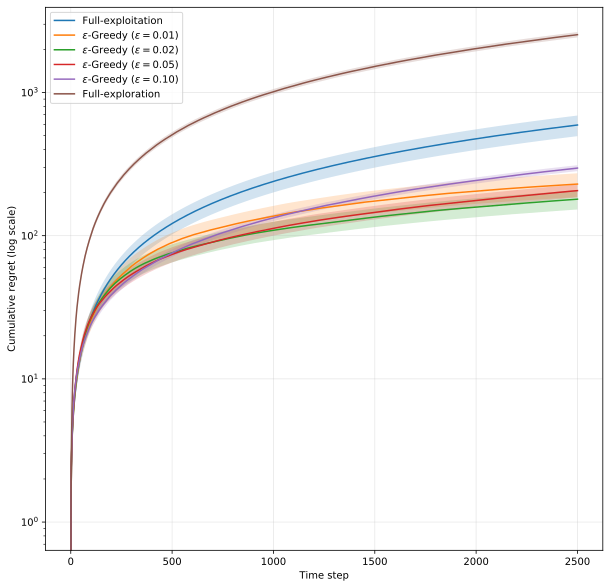

In [9]:
np.random.seed(1729)
epsilon_comparison(4, 2500, 500)

The results are as we would expect. The pure exploitative and exploratory strategies do not perform well at all, and the best strategy over this time-span appears to be the moderate $\varepsilon=0.02$. Despite this, we can see that the $\varepsilon = 0.01$ solver is likely set to overtake all others in the not too distant future, it just takes some time to make up for the regret it developed in the first 1000 steps whilst it was being slow to explore the available choices.

From now on, we will continue with just the pure strategies and the $0.02$-greedy policy, so that we can add two more approaches to our list without making our plot too messy.

### Don't Get Cocky

The $\varepsilon$-greedy approach described above can achieve some reasonable results but it has an obvious oversight. At no point in the policy definition do we ever try to quantify our uncertainty about our current estimates of the distribution means. This can lead to highly inefficient exploration. Imagine for example that we are confident that one distribution is far worse than the others. We may be close to certain of this fact yet when we complete the exploration step (occurring with probability $\varepsilon$) we have an uniform chance of picking this arm to explore and receiving a metric tonne of regret in response.

What we really want to do is favour exploring areas that have a strong potential for reward in the future. This way we can avoid exploring choices which we know are bad and spend more time looking for choices that could end up benefiting us significantly in the long-run. 

One way of implementing this thought process is using an upper confidence bound (UCB) policy. Rather than choosing an arm which maximises our current estimate of the means, we aim to maximise an upper bound on what this mean _could_ be with reasonable certainty given the information we have already received. There are many types of UCB algorithms which depend on our prior knowledge of what the reward distributions look like. We will keep it simple and use a method based on [Hoeffding's Inequality](http://cs229.stanford.edu/extra-notes/hoeffding.pdf) which requires no assumption of priors. I will summarise the mathematical details of this method in the technical details at the end of this post but for now I will just state the policy without justification:

* Suppose that on trial $t$, the $k$th arm has been pulled $N_k$ times
* Pick arm $k$ to maximise $\hat{\mu_k} + \sqrt{\frac{2\log t}{N_k}}$
* Update $\hat{\mu_k}$

Here, $\hat{\mu_k}$ is the same mean estimate we had with our purely exploitative method except now we add on the term $\sqrt{\frac{2\log t}{N_k}}$ to quantify the uncertainty of this estimate.

We will simulate this policy as before in just a moment. First though, let's turn to the statistical literature to see what it has to contribute to this problem.

In [10]:
class HoeffdingUCB(Solver):
    def __init__(self, bandit):
        super().__init__(bandit)
        self.mu_estimates = [0] * self.bandit.n
        self.trials = 0

    def reset(self):
        self.__init__(self.bandit)

    def run_one_step(self):

        choice = max(range(self.bandit.n), 
                     key=lambda i: self.mu_estimates[i] + 
                                   np.sqrt(2 * np.log(self.trials + 1) / (1 + self.counts[i])))
        
        r = self.bandit.generate_reward(choice)
        self.mu_estimates[choice] = ((self.counts[choice] * self.mu_estimates[choice] + r) /
                                    (self.counts[choice] + 1))

        self.trials += 1
        
        return choice

### Bring in the Big Guns

There's no point reinventing the wheel. In light of that, I decided to have a look at what papers had been published on the topic of multi-armed normal bandits with unknown means and variances. Lo and behold, in 2018, the trio Cowan, Honda, and Katehakis [published a paper](http://www.jmlr.org/papers/volume18/15-154/15-154.pdf) on this exact topic. The paper is a nice read and does a good job of comparing their policy to other existing methods as well as the Bayesian approach of Thompson Sampling. I appreciate that most don't have the time to read a 28-page paper on this topic so we will just skip to the policy definition:

* For the first $3n$ steps, sample each bandit three times

* For all other steps, pick arm $k$ to maximise $\hat{\mu_k} + \hat{\sigma^2_k}\sqrt{t^\frac{2}{N_k-2} - 1}$ 

* Update $\hat{\mu_k}$ and $\hat{\sigma^2_k}$

We define $t$ and $N_k$ as in the previous policy and denote $\hat{\sigma^2_k}$ to be the maximum likelihood estimator of the $k$th arm's variance—i.e. our 'best guess' at the square of the standard deviation (spread) of each reward distribution (more details in the technical notes).

With these two new policies introduced, let's return to our simulations.

In [11]:
class CHK(Solver):
    def __init__(self, bandit):
        super().__init__(bandit)
        self.mu_estimates = [0] * self.bandit.n
        self.var_estimates = [None] * self.bandit.n
        self.trials = 0

    def reset(self):
        self.__init__(self.bandit)

    def run_one_step(self):
        # start by sampling each bandit 3 times
        if self.trials < 3 * self.bandit.n:
            choice = self.trials // 3
        else:
            choice = max(range(self.bandit.n), 
                         key=lambda i: self.mu_estimates[i] + 
                                       self.var_estimates[i] * 
                                       sqrt(self.trials ** (2 / (self.counts[i] - 2)) - 1))
        
        r = self.bandit.generate_reward(choice)
        self.mu_estimates[choice] = ((self.counts[choice] * self.mu_estimates[choice] + r) /
                                    (self.counts[choice] + 1))
        if self.counts[choice] == 0:
            # variance undefined for one sample point
            pass
        elif self.counts[choice] == 1:
            self.var_estimates[choice] = (r - self.mu_estimates[choice]) ** 2
        else:
            self.var_estimates[choice] = ((self.counts[choice] * self.var_estimates[choice] + 
                                          (r - self.mu_estimates[choice]) ** 2 / self.counts[choice]) /
                                         (self.counts[choice] + 1))
        
        self.trials += 1
        
        return choice

In [12]:
def policy_comparison(n, num_steps, iterations):
    names = [
        'Full-exploitation',
        'Full-exploration',
        r'$\epsilon$-Greedy ($\epsilon=0.02$)',
        'UCB w/ Hoeffding\'s Inquality',
        'Cowan, Honda, Katehakis'
    ]
    
    regrets = [[] for _ in range(len(names))]
    for __ in range(iterations):
        bandit = NormalBandit(n)
        
        solvers = [
            EpsilonGreedy(bandit, 0),
            EpsilonGreedy(bandit, 1),
            EpsilonGreedy(bandit, 0.02),
            HoeffdingUCB(bandit),
            CHK(bandit)
        ]
        
        for j, s in enumerate(solvers):
            s.run(num_steps)
            regrets[j].append(s.regrets)

    plot_results(regrets, names)

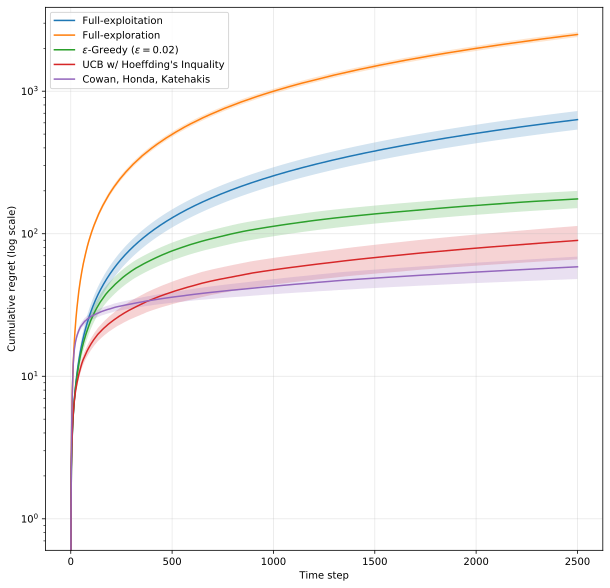

In [13]:
np.random.seed(1729)
policy_comparison(4, 2500, 500)

As would be expected, both the UCB and CHK policies perform far better than the simplistic approaches. Comparing the UCB and CHK policies is more difficult. The CHK policy takes a while to start performing well. This is because it begins by sampling each arm 3 times which may result in significant regret if one arm is much worse than the others. This exploration process has its benefits though, as the information gained from this process then allows CHK to significantly minimise its future regrets. In the end, the choice between these two efficient solvers comes down to how long you expect the game to last for.

## Conclusion

### A Whole New World

And so our whirlwind tour of the multi-armed bandit problem comes to a close. We have looked at a variety of approaches ranging from the naive and simplistic to state-of-the-art. Before I sign off, I would like to have a discussion regarding the applications of the multi-armed bandit problem to other disciplines as well as how reinforcement learning in general is becoming a key part of practical data science.

Out of the twelve pymetrics games, this one stood out to me the most due to its similarities with a problem that we have been discussing at my workplace. As some may know, I am currently undertaking a placement year as a data scientist at the drug company AstraZeneca. The nature of this field means that experimentation is often expensive and time-consuming. There are many situations in which we want to optimise a specific property of a compound over a space of tweak-able parameters yet performing a standard grid search as you would in traditional data science is impossible due to the cost. Instead, you have to decide on which experiments to perform in a deliberate manner, balancing the need to explore the entire space to make sure we don't get stuck in a local extremum, without wasting money searching fruitless areas of the parameter space. 

In fact, this problem goes much beyond the standard multi-armed bandit problem and begins to venture into the dark depths of reinforcement learning. One difference is that there are often many different types of experimentation that can be performed. On one end, we have access to chemical and statistical models which can be used to make predictions regarding how alterations in the parameter space affect the resultant compound. These models can be much quicker to run than a real experiment and are almost always orders of magnitude cheaper. The problem is that these methods are only approximations, subject to high variability (and perhaps even—eek!—bias). They may be cheap and quick but we can never trust their results as much as we could a lab-based experiment. 

To make matters even worse, we may have problems that are multi-objective: maximise solubility, whilst keeping melting point about a certain temperature, and make sure that the compound doesn't become too sticky. Reinforcement learning is certainly a rabbit hole yet the potential it offers is massive in these time and resource scarce scenarios. I hope that this introduction has opened your mind to the possibilities of the field and perhaps inspired you to read further into the topic.

<hr>

### Getting Technical

Okay, now for the nitty-gritty. If you aren't a fan of mathematics or statistics, it might not be wise to read on.

First I want to point out, that the code used to simulate the bandits and solvers in this post, as well as producing the visuals can be found on the [GitHub repository](https://github.com/THargreaves/ttested/tree/master/content) for this site.

There has been a lot of talk of regret. We can define this rigourously at time $t$ as

$$R(t) = \sum_{i=1}^t \left( \mu_{\theta^*} - \mu_{\theta_i}\right)$$

where $\theta_i$ is the choice we make at step $i$ and $\theta^*$ is the index of the best arm ($\theta^* = \textrm{argmax}_{i\in[n]} \mu_i$).

Next I would like to take some time to discuss the exact definitions of $\hat{\mu_k}$ and $\hat{\sigma^2_k}$ and how we can efficiently update them. If we define $r_i$ to be the reward received at time step $i$ we can then define for time step $t$

$$\hat{\mu_k} = \sum_{i=1}^t \frac{\mathbb{1}(\theta_i = k)r_i}{N_k}$$

$$\hat{\sigma^2_k} = \sum_{i=1}^t \frac{\mathbb{1}(\theta_i = k)(r_i - \hat{\mu_k})^2}{N_k}$$

where these estimates obviously depend on $t$. Note that the second estimator is biased. As noted in the Cowan-Honda-Katahakis, the paper's key result still holds when we use the standard unbiased estimator for variance ($N_k-1$ in the denominator).

Storing all rewards is inefficient in terms of storage and recalculating our estimates at each step is unthinkably slow. Instead, some messy—though relatively simple—algebra will show us that we can write

$$\hat{\mu_k}(t + 1) = \frac{N_k(t) \hat{\mu_k}(t) + r_t}{N_k(t) + 1}$$

$$\hat{\sigma^2_k}(t + 1) = \frac{N_k(t) \hat{\sigma^2_k}(t) + \frac{(r_t - \hat{\mu_k}(t))^2}{N_k(t)}}{N_k(t) + 1}$$

and so we only need to store the latest mean and variance estimates for each arm as we as the number of times we have used it in order to update our estimates. Full marks for efficiency!

Finally, I wanted to discuss how we reached the policy definition for the Hoeffding UCB. Hoeffding's Inequality applies to i.i.d random variables $X_1,\ldots, X_n$ and states that the sample mean $\bar{X_n} = \frac{1}{n}\sum_{i=1}^n X_i$ satisfies for any $u>0$,

$$\mathbb{P}\left[\mathbb{E}[X] > \bar{X_n} + u\right] \leq e^{-2nu^2}$$

In our case, at time $t$, if we define our upper confidence bound to be $U_k(t)$, we have,

$$\mathbb{P}\left[\mu_k > \hat{\mu_k}(t) + U_k(t)\right] \leq e^{-2N_k(t) U_k(t)^2}$$

We would like to pick a bound so that the likelihood that the true mean is below the sum of the mean estimate plus the upper confidence bound is small. In other words we would like a small $e^{-2tU_k(t)^2}$. Let this small probability be $p$ and we can rewrite,

$$e^{-2tU_k(t)^2} = p \iff U_k{t} = \sqrt{\frac{-\log p}{2N_k(t)}}$$

It would make sense to reduce the threshold $p$ with time so that our bounds become more confident as we observe more rewards. In the example above we chose $p = t^{-4}$ which gives $\hat{\mu_k} + \sqrt{\frac{2\log t}{N_k}}$ as we saw above.